<a href="https://colab.research.google.com/github/imTheDevil/Bridge-cmp-dmg-Detection-Transformer-based/blob/main/%5BPyTorchLgt%5D_Bridge_(dmg)_Detection_segformer_based_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Damage Detection Model**

##**References**

**Official Source Code for modeling PyTorch based SegFormer: https://github.com/NVlabs/SegFormer**

**Example notebooks for PyTorch SegFormer: https://colab.research.google.com/drive/1250K828ixr-sG2xzLVYYN5AVa3cTaDEF?usp=sharing**

**Blog Post on traning SegFormer using custom dataset: https://blog.roboflow.com/how-to-train-segformer-on-a-custom-dataset-with-pytorch-lightning/**

##**Model**

In [ ]:
pip install pytorch-lightning transformers datasets roboflow==0.2.7

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import random

In [ ]:
import platform
print("Python version:", platform.python_version())

import json
import sys
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

from PIL import Image
from io import BytesIO

Python version: 3.7.15


In [ ]:
path_ds = os.path.join('/content/drive/MyDrive','Tokaido Dataset') #path to the dataset

In [ ]:
json_filepath = os.path.join(path_ds, "id2label_dmg.json")

In [ ]:
#Function to change the path format 
def path_correct(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  return path

In [ ]:
#Loading the training data for damage images
#Access the csv file containing the absolute directory paths to each file

col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftrain = pd.read_csv(os.path.join(path_ds,'files_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))
ftrain.iloc[:,2] = ftrain.iloc[:,2].apply(lambda x: path_correct(x))
ftrain.iloc[:,3] = ftrain.iloc[:,3].apply(lambda x: path_correct(x))
#train_comp = ftrain.loc[ftrain['regular images']==True, ['image file name', 'component label file name']]
train_dmg = ftrain.loc[ftrain['images containing damage in the RRDR']==True, ['image file name', 'damage label file name']]

In [ ]:
train_dmg.head()

,image file name,damage label file name
0,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...
3,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...
5,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...
7,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...
11,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...


In [ ]:
#Loading the testing data for damage images
#Access the csv file containing the absolute directory paths to each file

col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftest = pd.read_csv(os.path.join(path_ds,'files_test.csv'),names = col_names,delimiter=',')
ftest.iloc[:,0] = ftest.iloc[:,0].apply(lambda x: path_correct(x))
ftest.iloc[:,1] = ftest.iloc[:,1].apply(lambda x: path_correct(x))
ftest.iloc[:,2] = ftest.iloc[:,2].apply(lambda x: path_correct(x))
ftest.iloc[:,3] = ftest.iloc[:,3].apply(lambda x: path_correct(x))
#test_comp = ftest.loc[ftest['regular images']==True, ['image file name', 'component label file name']]
test_dmg = ftest.loc[ftest['images containing damage in the RRDR']==True, ['image file name', 'damage label file name']]

In [ ]:
test_dmg.head()

,image file name,damage label file name
6,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...
13,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...
14,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...
24,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...
28,/content/drive/MyDrive/Tokaido Dataset/img_syn...,/content/drive/MyDrive/Tokaido Dataset/synthet...


In [ ]:
jsfile = json.load(open(os.path.join(path_ds, 'id2label_dmg.json'), "r"))
idlab = {int(k): v for k, v in jsfile.items()}

In [ ]:
len(idlab.keys())

4

In [ ]:
#training and validation split
train = train_dmg[:2000]
val = train_dmg[2001:2500]
#testing dataset size split
test = train_dmg[100:300]

In [ ]:
class SemanticSegmentationDataset(Dataset):

    def __init__(self, root_dir, feature_extractor, dataframe):   #dataframe: dataset of paths of images and corresponding labels
        
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.dataframe = dataframe 

        data = json.load(open(os.path.join(self.root_dir, 'id2label_dmg.json'), "r"))
        self.id2label = {int(k): v for k, v in data.items()}
        
        self.images = list(self.dataframe['image file name'])
        self.masks = list(self.dataframe['damage label file name'])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(self.images[idx])
        segmentation_map = Image.open(self.masks[idx])

        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt") # randomly crop + pad both image and segmentation map to same size

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # removes "batch" dimension

        return encoded_inputs

In [ ]:
class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        
        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        
        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        
    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)
    
    def training_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            
            for k,v in metrics.items():
                self.log(k,v)
            
            return(metrics)
        else:
            return({'loss': loss}) #Calculates all required metrics at specified metrics interval or otherwise calculates loss after each batch
    
    def validation_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear" 
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        
        return({'val_loss': loss})
    
    def validation_epoch_end(self, outputs):
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
        
        avg_val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]
        
        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        return metrics
    
    def test_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear"
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
            
        return({'test_loss': loss})
    
    def test_epoch_end(self, outputs): 
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
       
        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}
        
        for k,v in metrics.items():
            self.log(k,v)
        
        return metrics
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl
    

        

In [ ]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.reduce_labels = False
feature_extractor.size = 216

Downloading:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [ ]:
train_dataset = SemanticSegmentationDataset(path_ds, feature_extractor, train)
val_dataset = SemanticSegmentationDataset(path_ds, feature_extractor, val)
test_dataset = SemanticSegmentationDataset(path_ds, feature_extractor, test)

batch_size = 4
num_workers = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader,
    metrics_interval=3,
)

Downloading:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([4, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


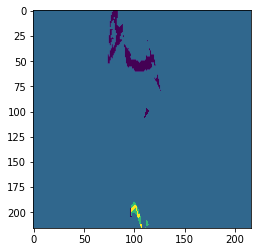

In [ ]:
plt.imshow(test_dataset[0]['labels'])

In [ ]:
train_dataset.__getitem__(0)

{'pixel_values': tensor([[[-1.4672, -1.1075, -1.2103,  ..., -1.3815, -1.4329, -1.2788],
         [-1.4843, -1.4329, -1.4843,  ..., -1.1589, -1.2445, -1.1932],
         [-1.3987, -1.5185, -1.5699,  ..., -1.2617, -1.3815, -1.2617],
         ...,
         [-1.5699, -1.1247, -1.1760,  ..., -1.3130, -1.4500, -1.3644],
         [-1.6042, -1.5870, -1.6898,  ..., -1.6042, -1.9124, -1.8953],
         [-1.8097, -1.7583, -1.6727,  ..., -1.4500, -1.8439, -1.9295]],

        [[-1.0203, -0.6702, -0.8627,  ..., -0.4601, -0.6001, -0.4601],
         [-1.1429, -1.0728, -1.1604,  ..., -0.2675, -0.3901, -0.3550],
         [-1.0728, -1.2304, -1.2479,  ..., -0.5126, -0.5826, -0.4776],
         ...,
         [-1.0903, -0.3901, -0.3550,  ..., -0.8102, -0.7752, -0.5476],
         [-1.1779, -1.0903, -1.2479,  ..., -1.1954, -1.5805, -1.4755],
         [-1.3880, -1.3004, -1.1253,  ..., -1.0028, -1.6331, -1.6856]],

        [[-1.0724, -0.7413, -0.9156,  ..., -0.8807, -0.9504, -0.7064],
         [-1.1421, -1.0724, 

In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=5, 
    verbose=False, 
    mode="min",
)

checkpoint_callback = ModelCheckpoint(monitor="val_loss", 
                                      dirpath = "/content/drive/MyDrive/PyTorch segformer/damage/trail1", 
                                      filename='{epoch}-{val_loss:.2f}-{val_mean_iou:.2f}-{loss:.2f}',
                                      save_last=True,
                                      save_top_k=-1,
                                      save_weights_only=True)

trainer = pl.Trainer(
    accelerator = "gpu",
    devices = 1, 
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=20,
    val_check_interval=len(train_dataloader),
)
trainer.fit(segformer_finetuner)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/drive/MyDrive/PyTorch segformer/damage/trail1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
res = trainer.test(ckpt_path="/content/drive/MyDrive/PyTorch segformer/damage/trail1/last.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/PyTorch segformer/damage/trail1/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/PyTorch segformer/damage/trail1/last.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.05236123129725456
   test_mean_accuracy       0.42980278577269715
      test_mean_iou         0.3858995780495155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
color_map = {
    0:(0,0,0),
    1:(255,255,255),
    2:(0,0,255),
    3:(255,0,0)
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))


In [ ]:
batchnum = 1
i=0

for batch in test_dataloader:
    i = i+1
    images, masks = batch['pixel_values'], batch['labels']
    outputs = segformer_finetuner.model(images, masks)
        
    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits, 
        size=masks.shape[-2:], 
        mode="bilinear"
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()
    if(i==batchnum):
      break

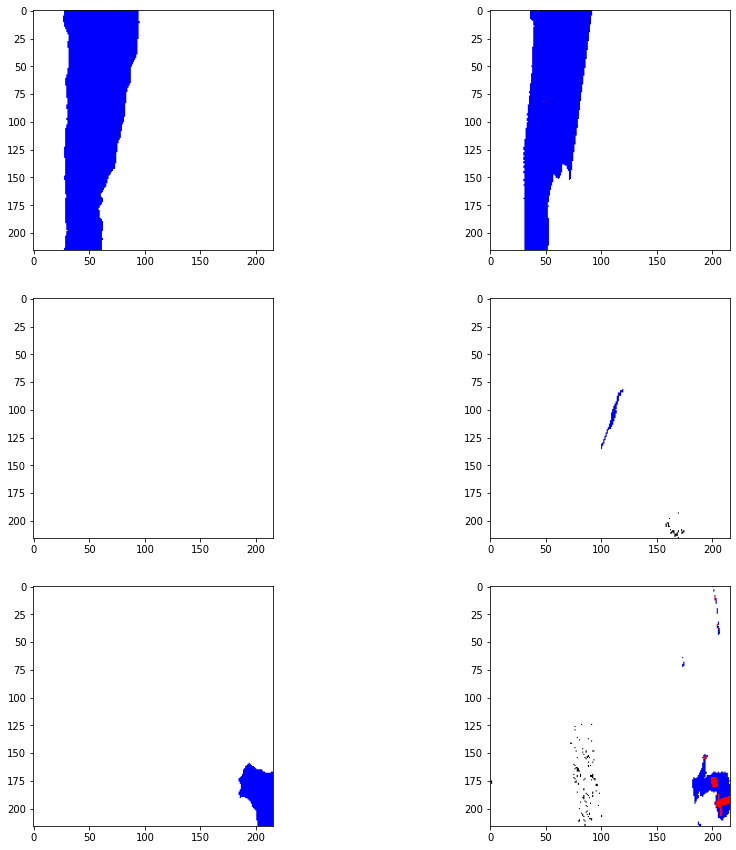

In [ ]:
n_plots = 3
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))